### Import required Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gym
import deap
from stable_baselines3 import PPO

### 1. Create Sample Shelves Dataset

In [11]:
class AntColony:
    def __init__(self, distance_matrix, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances = distance_matrix
        self.pheromone = np.ones(self.distances.shape) / len(distance_matrix)
        self.all_inds = range(len(distance_matrix))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        all_time_shortest_path = ("placeholder", np.inf)
        for _ in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheromone(all_paths, self.n_best)
            shortest_path = min(all_paths, key=lambda x: x[1])  # x[1] is the distance
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone *= self.decay  # Apply decay

        return all_time_shortest_path

    def spread_pheromone(self, all_paths, n_best):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])  # Sort based on distance
        for path, dist in sorted_paths[:n_best]:  # Take n_best paths
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for i in range(len(path) - 1):
            total_dist += self.distances[path[i]][path[i + 1]]  # Compute distance from current to next
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for _ in range(self.n_ants):
            path = self.gen_path(0)  # Start at shelf 0
            path_distance = self.gen_path_dist(path)
            all_paths.append((path, path_distance))  # Append path and its distance
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for _ in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append(move)
            prev = move
            visited.add(move)
        path.append(start)  # Returning to start
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0  # Block visited nodes
        dist = np.where(dist == 0, np.inf, dist)
        row = pheromone * self.alpha * ((1.0 / dist) * self.beta)

        if np.sum(row) == 0:
            return np.random.choice(list(set(self.all_inds) - visited))

        norm_row = row / row.sum()
        move = np.random.choice(list(self.all_inds), p=norm_row)
        return move

In [12]:
orders_df = pd.read_csv('./orders.csv')
shelves_df = pd.read_csv('./Shelves.csv')
robots_df = pd.read_csv('./robots.csv')

### 2. Create a NumPy array for shelf locations

In [13]:
shelves_locations = shelves_df[['Location_X', 'Location_Y']].to_numpy()

### 3. Define the Distance Matrix Function

In [14]:
def shelf_distance(s1, s2):
    if not (0 <= s1 < len(shelves_locations)) or not (0 <= s2 < len(shelves_locations)):
        raise IndexError(f"Invalid index: s1={s1}, s2={s2} for shelves_locations with size {len(shelves_locations)}")
    return np.linalg.norm(shelves_locations[s1] - shelves_locations[s2])

In [15]:
# Create a distance matrix
num_shelves = len(shelves_locations)
distance_matrix = np.zeros((num_shelves, num_shelves))

for i in range(num_shelves):
    for j in range(num_shelves):
        distance_matrix[i][j] = shelf_distance(i, j)

### 4. Implement the Ant Colony Optimization Class

In [16]:
# 5. Initialize and Run the Ant Colony Optimization
aco = AntColony(distance_matrix, n_ants=5, n_best=2, n_iterations=100, decay=0.95)
best_shelf_route = aco.run()

print("Best shelf route:", best_shelf_route)

Best shelf route: ([np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(19), np.int64(18), np.int64(17), np.int64(2), np.int64(1), 0], np.float64(102.90576204178633))


C:\Users\premd\AppData\Local\Temp\ipykernel_31280\850909146.py:29: RuntimeWarning: divide by zero encountered in divide
  self.pheromone[move] += 1.0 / self.distances[move]


In [17]:
class WarehouseEnv(gym.Env):
    def __init__(self, robot_id, assigned_orders):  # Accept robot ID and orders
        super(WarehouseEnv, self).__init__()
        self.robot_id = robot_id
        self.assigned_orders = assigned_orders
        self.action_space = gym.spaces.Discrete(num_shelves)  # Pick a shelf
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

    def reset(self):
        self.state = np.zeros(2)  # Reset warehouse state to start position
        return self.state

    def step(self, action):
        distance_to_shelf = shelf_distance(int(self.state[0]), action)  # Get distance
        reward = -distance_to_shelf  # Penalize distance
        self.state[0] = action  # Update the current shelf
        done = False  # Indicate whether the episode is done
        return self.state, reward, done, {}

### 6. Create the Gym Environment for Reinforcement Learning

In [18]:
# 7. Assign orders to robots (randomly for demonstration)
num_robots = len(robots_df)
orders_to_robots = {i: [] for i in range(num_robots)}
for index, order in orders_df.iterrows():
    assigned_robot = random.choice(range(num_robots))  # Assign order to a robot based on robot status
    orders_to_robots[assigned_robot].append(order)


In [19]:
models = {}
for robot_id, assigned_orders in orders_to_robots.items():
    env = WarehouseEnv(robot_id, assigned_orders)
    model = PPO("MlpPolicy", env, verbose=1) # proximal policy optimization, robot = agent, decision = policy, state = op, reward = feedback used for next decision
    model.learn(total_timesteps=10000)
    models[robot_id] = model

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\Academics\20XW58\Robotic-Mobile-Fulfillment-System\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 3963 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2065         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.010972012  |
|    clip_fraction        | 0.091        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.99        |
|    explained_variance   | 7.456541e-05 |
|    learning_rate        | 0.0003       |
|    loss                 | 5.03e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0198      |
|    value_loss           | 1.04e+05     |
------------------------------------------
----------------

d:\Academics\20XW58\Robotic-Mobile-Fulfillment-System\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 3963 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2109         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.013991577  |
|    clip_fraction        | 0.167        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.99        |
|    explained_variance   | -0.000613451 |
|    learning_rate        | 0.0003       |
|    loss                 | 5.46e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0274      |
|    value_loss           | 1.01e+05     |
------------------------------------------
----------------

### 7. Train the RL Model

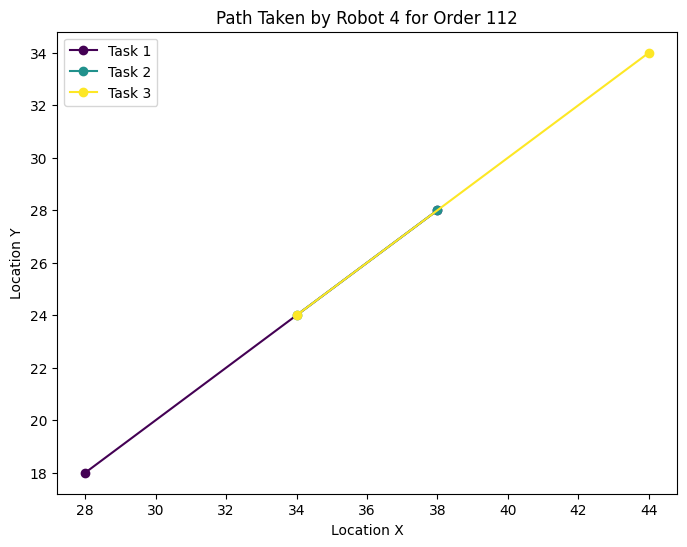

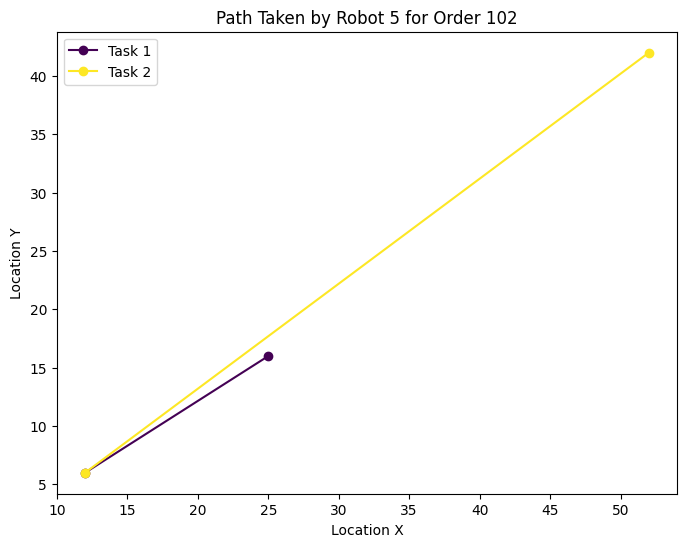

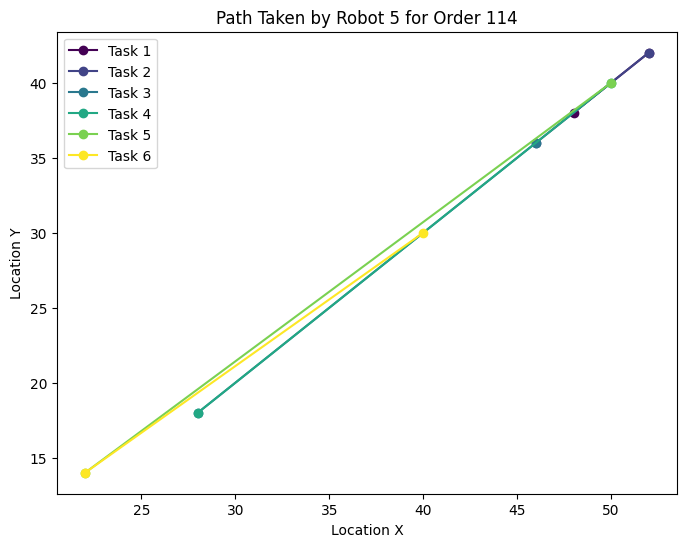

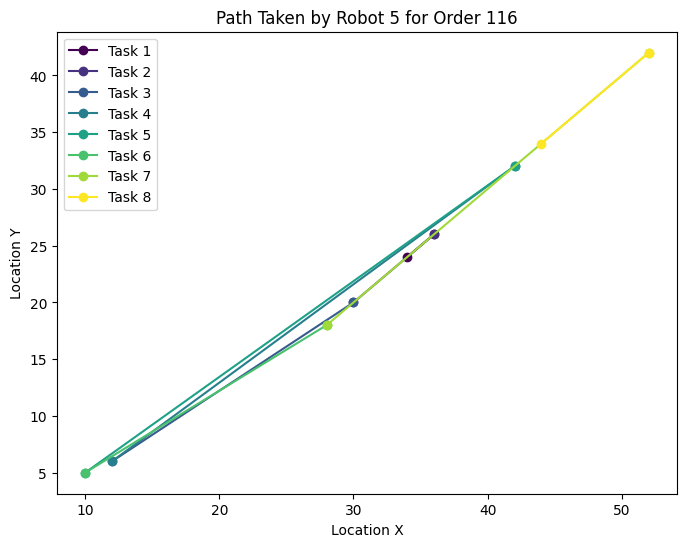

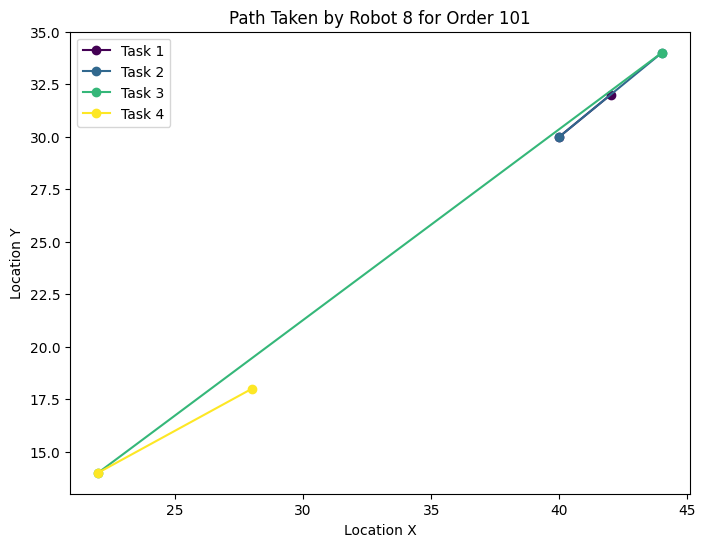

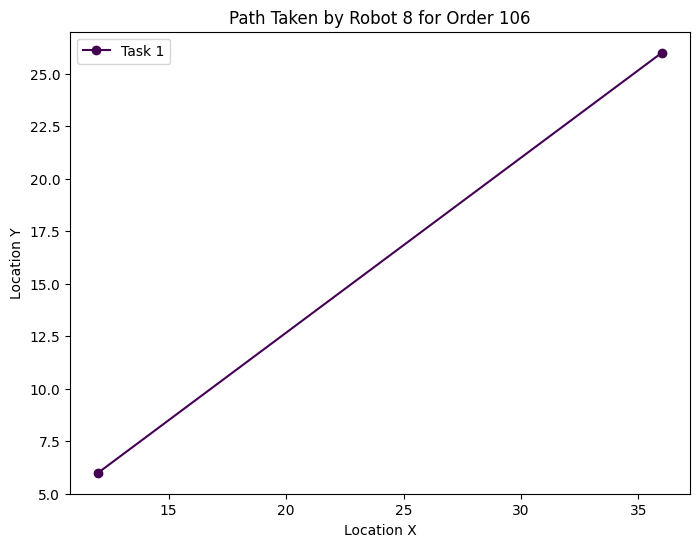

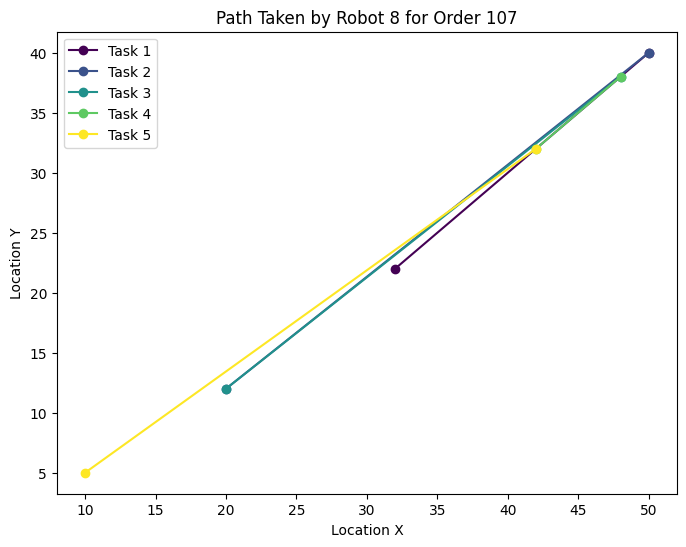

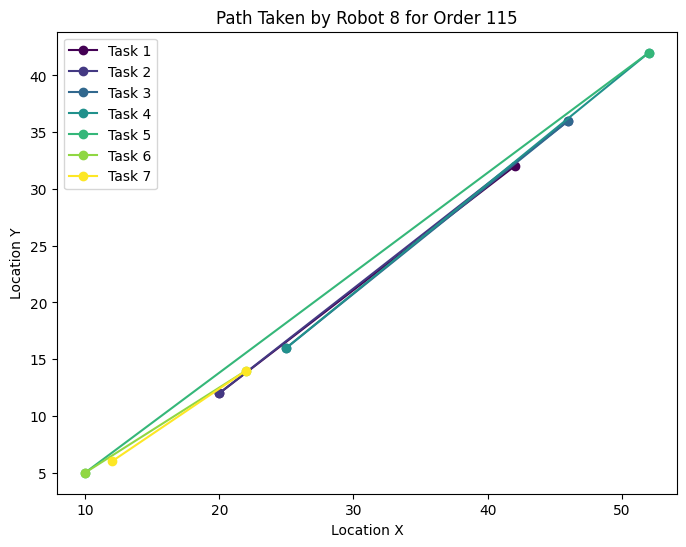

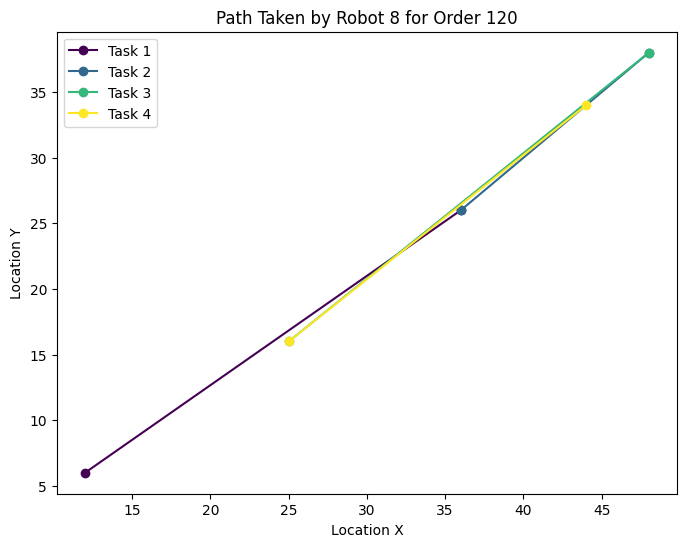

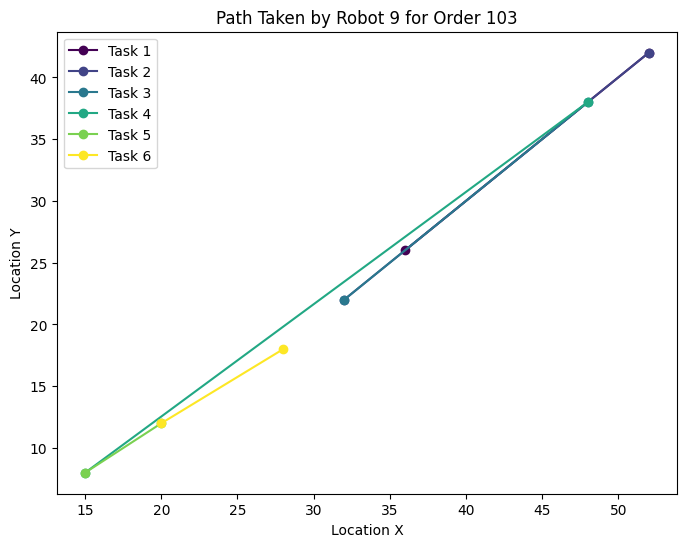

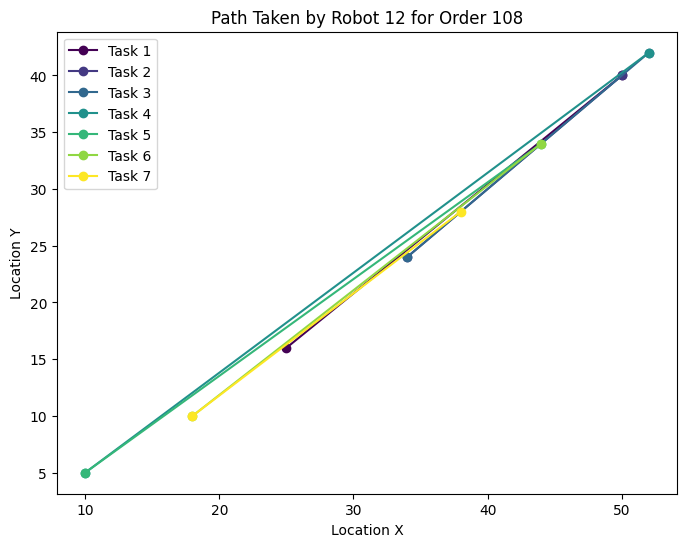

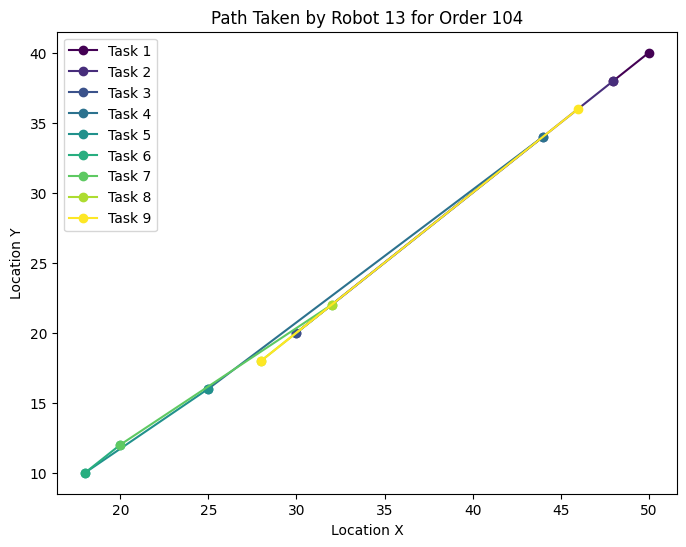

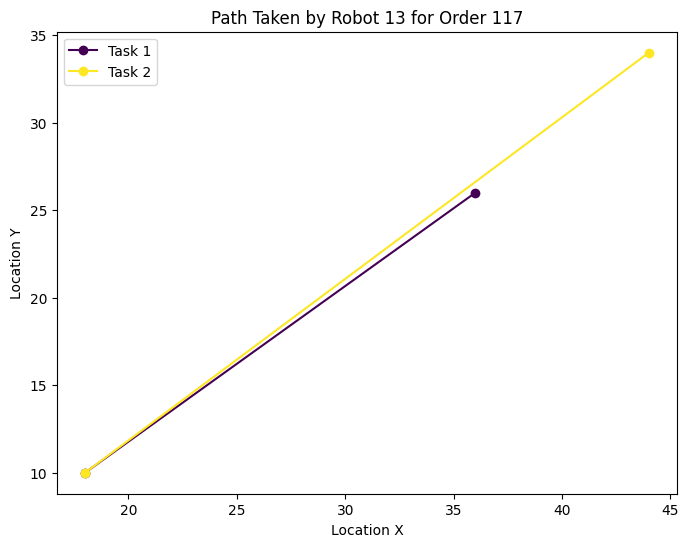

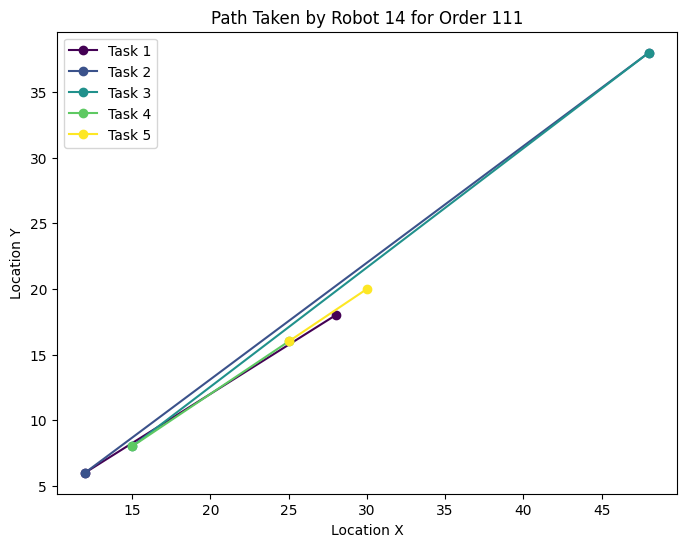

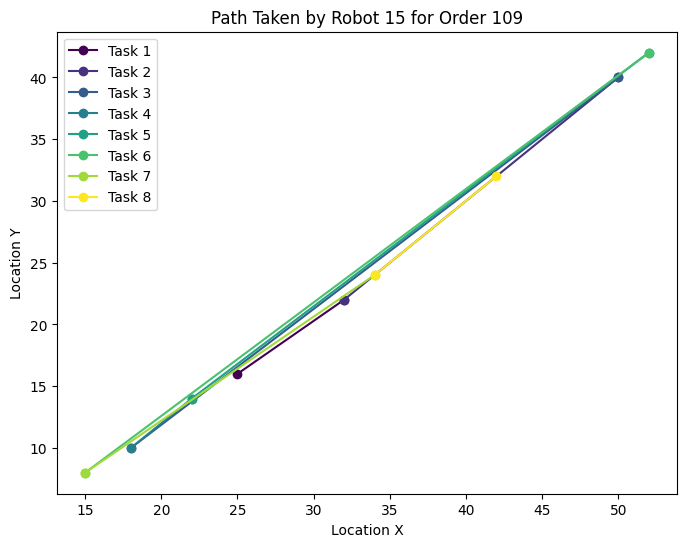

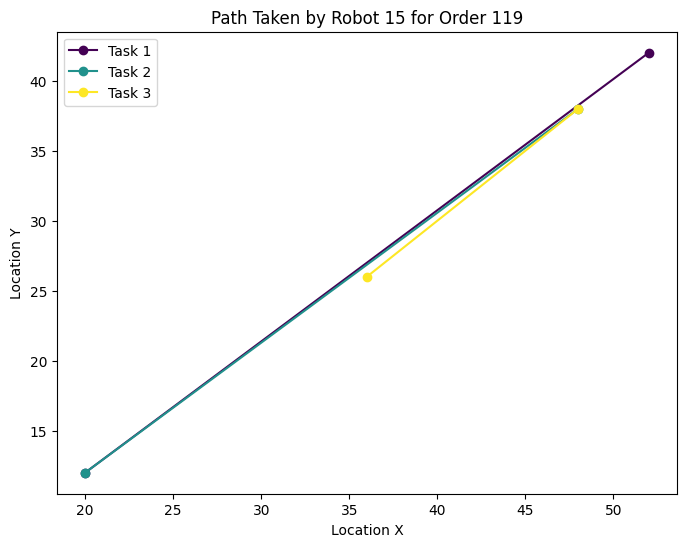

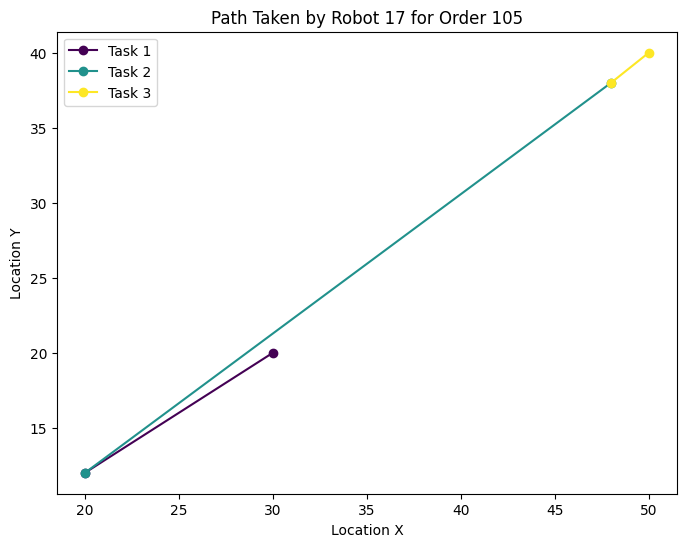

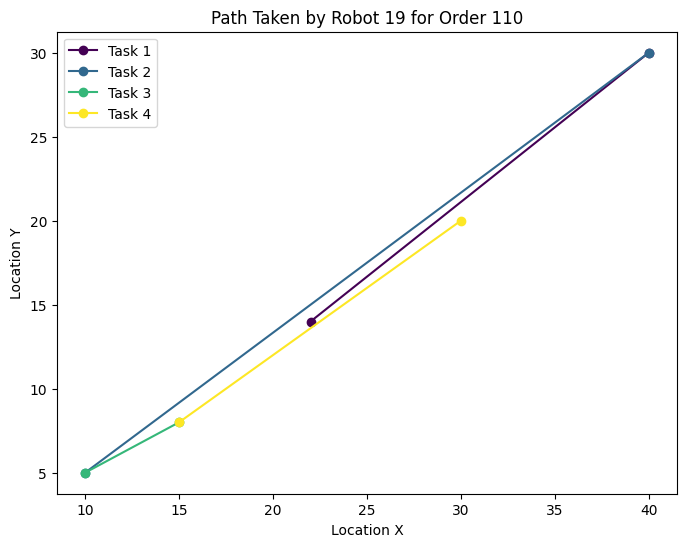

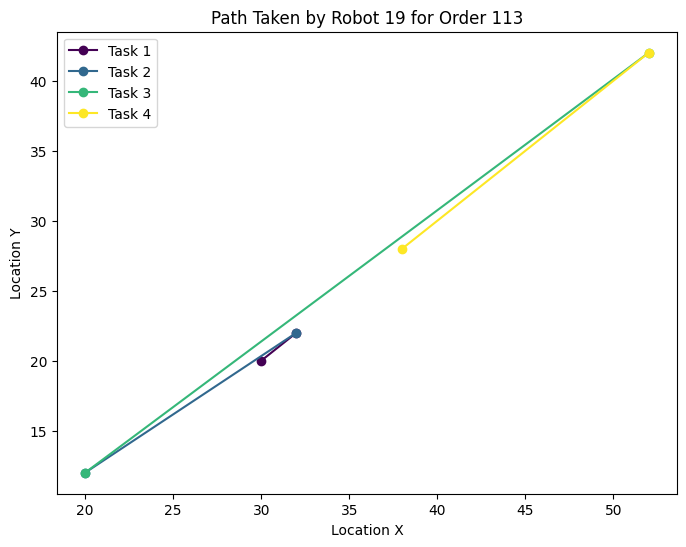

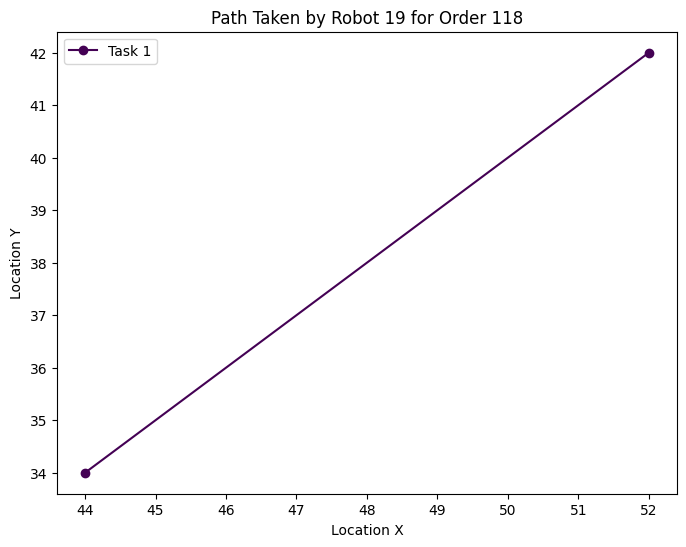

In [20]:
# 8. Test the trained models for all robots
for robot_id, model in models.items():
    env = WarehouseEnv(robot_id, orders_to_robots[robot_id])
    obs = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            break

    # Visualization for each robot's assigned tasks
    selected_robot_orders = orders_to_robots[robot_id]

    # Create separate plots for each order assigned to the robot
    for order in selected_robot_orders:
        plt.figure(figsize=(8, 6))

        # This should be modified to extract actual shelf IDs based on your application logic
        shelves_to_pick = np.random.choice(range(len(shelves_df)), size=min(order['Number_of_Items'], len(shelves_df)), replace=False)

        # Create a list of colors for each leg of the route
        colors = plt.cm.viridis(np.linspace(0, 1, len(shelves_to_pick) - 1))

        for i in range(len(shelves_to_pick) - 1):
            x1, y1 = shelves_df[['Location_X', 'Location_Y']].iloc[shelves_to_pick[i]].values
            x2, y2 = shelves_df[['Location_X', 'Location_Y']].iloc[shelves_to_pick[i + 1]].values

            # Plot each leg with a different color
            plt.plot([x1, x2], [y1, y2], color=colors[i], marker='o', label=f'Task {i + 1}')

        # Adding title and labels
        plt.title(f'Path Taken by Robot {robot_id + 1} for Order {order["Order_ID"]}')
        plt.xlabel('Location X')
        plt.ylabel('Location Y')

        # Adding a legend to differentiate tasks
        plt.legend(loc='best')

        plt.show()

### 8. Test the trained model

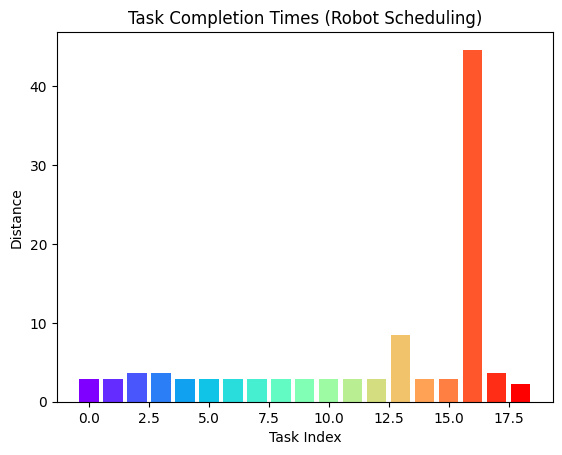

In [21]:

# Bar plot for the best shelf route
colors = plt.cm.rainbow(np.linspace(0, 1, len(best_shelf_route[0]) - 1))

plt.bar(range(len(best_shelf_route[0]) - 1),
        [shelf_distance(best_shelf_route[0][i], best_shelf_route[0][i + 1]) for i in range(len(best_shelf_route[0]) - 1)],
        color=colors)

# Adding titles and labels
plt.title('Task Completion Times (Robot Scheduling)')
plt.xlabel('Task Index')
plt.ylabel('Distance')

plt.show()
